In [1]:
import numpy as np
from sklearn.linear_model import RANSACRegressor
from sklearn.datasets import make_regression

# Generate sample data
X, y = make_regression(n_samples=100, n_features=1, noise=10, random_state=42)
X = X.flatten()

# Add outliers
np.random.seed(42)
n_outliers = 10
X_outliers = np.random.uniform(-3, 3, n_outliers)
y_outliers = np.random.uniform(-200, 200, n_outliers)
X = np.concatenate([X, X_outliers])
y = np.concatenate([y, y_outliers])

# Reshape X for fitting
X = X.reshape(-1, 1)

# Fit RANSAC
ransac = RANSACRegressor()
ransac.fit(X, y)

# Get inlier mask
inlier_mask = ransac.inlier_mask_  # Boolean array: True = inlier, False = outlier

# Separate inliers and outliers
X_inliers = X[inlier_mask]
y_inliers = y[inlier_mask]
X_outliers = X[~inlier_mask]
y_outliers = y[~inlier_mask]

# Print results
print(f"Number of inliers: {len(X_inliers)}")
print(f"Number of outliers: {len(X_outliers)}")


Number of inliers: 97
Number of outliers: 13


Best Homography Matrix:
[[ 1.30142180e+00 -8.77093207e-01  1.96113744e+02]
 [-3.67772512e-01  6.67298578e-01  1.91279621e+02]
 [-6.20853081e-03  4.96050553e-03  1.00000000e+00]]
Number of Inliers: 4
Number of Outliers: 2


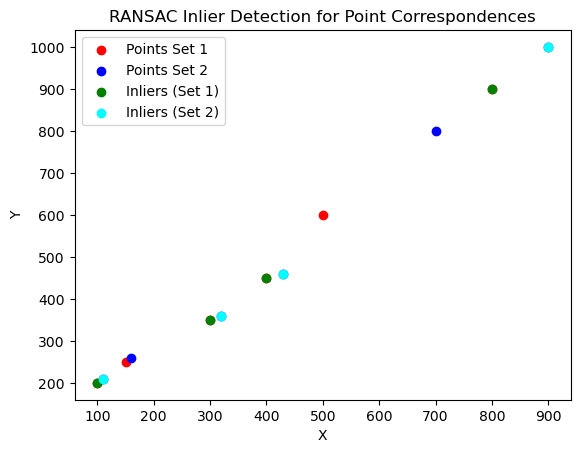

In [15]:
import numpy as np
import random

def ransac_point_matching(points1, points2, max_iterations=1000, threshold=5.0):
    """
    RANSAC for 2D point correspondences to identify inliers.

    Parameters:
    - points1: Nx2 array of 2D points from image 1.
    - points2: Nx2 array of 2D points from image 2.
    - max_iterations: Number of RANSAC iterations.
    - threshold: Reprojection error threshold for inliers.

    Returns:
    - best_inliers_mask: Boolean mask of inliers.
    - best_transform: 3x3 homography matrix estimated from inliers.
    """

    def estimate_transform(p1, p2):
        """Estimate a homography using exactly 4 points."""
        return cv2.getPerspectiveTransform(p1, p2)

    def compute_reprojection_error(H, p1, p2):
        """Compute the reprojection error for all points."""
        p1_h = np.hstack([p1, np.ones((p1.shape[0], 1))])  # Convert to homogeneous
        p2_proj_h = (H @ p1_h.T).T                          # Transform points
        p2_proj = p2_proj_h[:, :2] / p2_proj_h[:, 2:]       # Back to Cartesian
        return np.linalg.norm(p2 - p2_proj, axis=1)         # Euclidean distance

    best_inliers_mask = None
    best_inliers_count = 0
    best_transform = None

    for i in range(max_iterations):
        # Step 1: Randomly select 4 point pairs
        indices = random.sample(range(len(points1)), 4)
        subset1 = points1[indices]
        subset2 = points2[indices]

        # Step 2: Estimate the transformation (homography)
        try:
            H = estimate_transform(subset1.astype(np.float32), subset2.astype(np.float32))
        except Exception:
            print(i, "ERROR")
            continue  # Skip degenerate cases

        # Step 3: Calculate reprojection errors for all correspondences
        errors = compute_reprojection_error(H, points1, points2)

        # Step 4: Identify inliers
        inliers_mask = errors < threshold
        inliers_count = np.sum(inliers_mask)

        # Step 5: Update the best model if current one is better
        if inliers_count > best_inliers_count:
            best_inliers_count = inliers_count
            best_inliers_mask = inliers_mask
            best_transform = H

    return best_inliers_mask, best_transform

# Example: Using the function
import cv2
import matplotlib.pyplot as plt

# Example correspondences (some incorrect ones included)
points1 = np.array([[100, 200], [150, 250], [300, 350], [400, 450], [500, 600], [800, 900]])
points2 = np.array([[110, 210], [160, 260], [320, 360], [430, 460], [700, 800], [900, 1000]])

# Run RANSAC
inliers_mask, best_transform = ransac_point_matching(points1, points2)

# Separate inliers and outliers
inliers1 = points1[inliers_mask]
inliers2 = points2[inliers_mask]
outliers1 = points1[~inliers_mask]
outliers2 = points2[~inliers_mask]

# Print results
print(f"Best Homography Matrix:\n{best_transform}")
print(f"Number of Inliers: {np.sum(inliers_mask)}")
print(f"Number of Outliers: {np.sum(~inliers_mask)}")

# Visualize the results
plt.scatter(points1[:, 0], points1[:, 1], color="red", label="Points Set 1")
plt.scatter(points2[:, 0], points2[:, 1], color="blue", label="Points Set 2")
plt.scatter(inliers1[:, 0], inliers1[:, 1], color="green", label="Inliers (Set 1)")
plt.scatter(inliers2[:, 0], inliers2[:, 1], color="cyan", label="Inliers (Set 2)")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("RANSAC Inlier Detection for Point Correspondences")
plt.show()


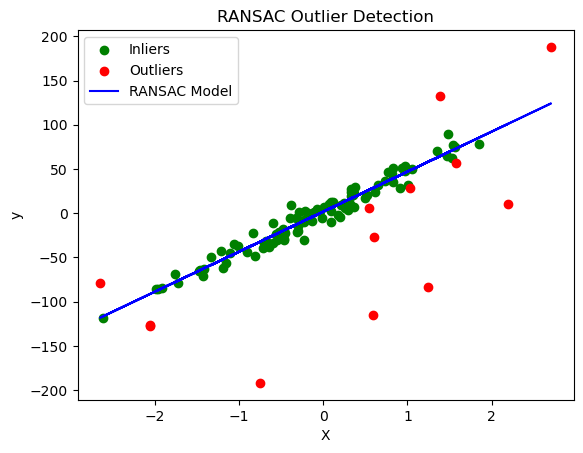

In [2]:
import matplotlib.pyplot as plt

plt.scatter(X_inliers, y_inliers, color="green", label="Inliers")
plt.scatter(X_outliers, y_outliers, color="red", label="Outliers")
plt.plot(X, ransac.predict(X), color="blue", label="RANSAC Model")
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
plt.title("RANSAC Outlier Detection")
plt.show()


In [2]:
%load_ext autoreload
%notebook autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import geopandas as gpd
from scipy.spatial import KDTree
from tqdm.autonotebook import tqdm
from scipy.ndimage import gaussian_filter
from fuzzywuzzy import process
import contextily as cx

from IndexUtils import * 
from TileUtils import *
from featurematching import *

# TILED INFERENCE
import sahi
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict
from scipy.spatial.distance import cdist

from scipy.fftpack import fft2, ifft2, fftshift
from scipy.ndimage import center_of_mass

from sklearn.cluster import DBSCAN

from skimage.morphology import skeletonize

from scipy.interpolate import Rbf

C:\Users\fhacesga\AppData\Local\Temp\ipykernel_28292\2864581687.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


In [4]:
corners = gpd.read_file(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\OSM_Roads\TexasRoads_filtered_strict_3857_nondupe_smaller_harris.gpkg")
roads_gdf = gpd.read_file(r"C:\Users\fhacesga\Downloads\TexasRoads_filtered_strict_3857.gpkg", engine='pyogrio', use_arrow=True)

In [5]:
with open("SmartDictV2.p", 'rb') as f:
    tile_coords = pickle.load(f)

In [6]:
with open(r"D:\RECTDNN\processing\2024-10-11_15-08-46\street_corners\exp7\pickles\48201C0660L.pickle", 'rb') as f:
    x = pickle.load(f)    
    corner_bbox = [a.bbox.to_xyxy() for a in x if a.score.value > 0.001]
    corner_arry = np.array([calcCenter(a) for a in corner_bbox ]) * 2
    print(f"{len(corner_bbox)} / {len(x)}")

1331 / 1331


In [7]:
# r"D:\RECTDNN\processing\2024-10-11_15-08-46\referencing\48201C0930J.tif"
im_file    = r"D:\RECTDNN\processing\2024-10-11_15-08-46\referencing\48201C0660L.tif"
him_file   = r"D:\RECTDNN\processing\2024-10-11_15-08-46\half_size\48201C0660L.tif"

curr_tn = os.path.basename(im_file.split(".")[0])[:-1]
curr_tf = os.path.basename(im_file.split(".")[0])[-1]

ra = rio.open(im_file)
bounds  = ra.bounds
image   = ra.read(1)

bounds, RLNN = findBounds(im_file, None)
bbox = bounds[0].boxes.xyxy.numpy().astype(np.int32)[0].flatten()

real_x, real_y = bbox_to_coords_realworld(tile_coords[curr_tn][curr_tf]["coords"][0])
pic_x, pic_y   = bbox_to_coords_raster(bbox)

affine = affineTransformation(pic_x, pic_y, real_x, real_y)

# corner_arry = streetcorners[os.path.basename(tile).split(".")[0] + ".pickle"] * 2# streetresults_struct[tile_coords[out_name]['input_file']]
corner_arry = np.int32(corner_arry)                 # CONVERT TO INT32
corner_arry = cleanCenterBBOX(corner_arry, bbox)

# USE RASTER TRANSFORM TO GET REAL-WORLD ESTIMATES OF STREET CORNERS
im_corner_gdf = pointsToGeodataFrame(ra, corner_arry[:, 1], corner_arry[:, 0])

bounds_poly = enlarged_bounds(ra, n=2)

descriptor_kwds = {
    "angle_step"        : 5,
    "azimuth_radius"    : 500
}

corners, _ = calcDescriptors(corners, **descriptor_kwds)
corners_curr = gpd.clip(corners, bounds_poly)

  0%|          | 0/127256 [00:00<?, ?it/s]

In [8]:
roads_clipped = gpd.clip(roads_gdf, bounds_poly)    # CLIP
streets = getRoadPoints(roads_clipped, 0.5)         # ROAD POINTS ALONG STREETS, 0.5 IN M

model = TPNN(num_classes=2, finalpadding=1, inputsize=2)
checkpoint = torch.load(r'C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data/FANN/checkpoint_101123.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to('cuda')

roads, _    = split_and_run_cnn(image, model, tilesize=1024, num_dim=3, edges=10, dims_rep=[0], n_pyramids=2, device="cuda", verbose=True)
roads_thin  = roads[:, :, 1] > 0.95
roads_thin  = cleanImageBBOX(roads_thin, bbox)
roads_thin  = skeletonize(roads_thin)    # USE SKELETONIZATION ALGORITHM TO THIN ROADS
y, x        = np.where(roads_thin[:, :])            # GET X, Y COORDINATES OF IDENTIFIED ROAD POINTS
street_det  = pointsToGeodataFrame(ra, y, x)        # CONVERT X, Y COORDINATES TO GDF AND REPROEJCT TO CURRENT ESTIMATE OF RASTER POSITION

  0%|          | 0/11 [00:00<?, ?it/s]

In [86]:
def iterativeAdjustFromMatching(matchresults, corners_curr=None, idx=None, im_corner_gdf=None, plot=False):
    if idx is None:
        idx = np.arange(len(matchresults), dtype=np.int32)
    
    if len(matchresults[0]) > 4:
        fromPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[4][0] for x in matchresults], [x[4][1] for x in matchresults]))
        toPoints   = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[5][0] for x in matchresults], [x[5][1] for x in matchresults]))
    else:
        fromPoints = np.vstack((np.array(corners_curr.iloc[np.array(matchresults)[idx, 1]].geometry.x), np.array(corners_curr.iloc[np.array(matchresults)[idx, 1]].geometry.y))).T
        toPoints = np.vstack((np.array(im_corner_gdf.iloc[np.array(matchresults)[idx, 0]].geometry.x), np.array(im_corner_gdf.iloc[np.array(matchresults)[idx, 0]].geometry.y))).T
        fromPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy(fromPoints[:, 0], fromPoints[:, 1]))
        toPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy(toPoints[:, 0], toPoints[:, 1]))

        

    initial = affineTransformation(fromPoints.iloc[idx].geometry.x.to_numpy(), 
                                    fromPoints.iloc[idx].geometry.y.to_numpy(), 
                                    toPoints.iloc[idx].geometry.x.to_numpy(), 
                                    toPoints.iloc[idx].geometry.y.to_numpy(), verbose=False)
    matrix = initial.matrix

    coordsA = getCoordsGDF(fromPoints)
    coordsB = getCoordsGDF(toPoints)

    coordsA, coordsB = normCoords(coordsA, coordsB)

    checker = True
    prev = np.where(idx)[0].shape[0]

    while checker:
        initial = affineTransformation(coordsA[idx, 0], coordsA[idx, 1], coordsB[idx, 0], coordsB[idx, 1],verbose=False)

        matrix = initial.matrix        
        coordsBprime = np.hstack((coordsB[idx], np.ones((coordsB[idx].shape[0], 1)))) @ np.linalg.inv(matrix).T
        distances = np.sqrt((coordsBprime[:, 0] - coordsA[idx, 0]) ** 2 + (coordsBprime[:, 1] - coordsA[idx, 1]) ** 2)
        uv = coordsB - coordsA
        angles = np.degrees(np.arctan2(uv[:, 1], uv[:, 0]))
        test = np.vstack((normArry(angles), normArry(np.sqrt(uv[:, 0] ** 2, uv[:, 1] ** 2 )))).T
        test[np.isnan(test)] = 0
        idx = most_popular_indices_2d(test, eps=0.01)

        if np.where(idx)[0].shape[0] < prev:
            prev = np.where(idx)[0].shape[0]
        else: 
            checker = False
        print(prev)
        
    if plot:

        fig, axs = plt.subplots(1, 2)
        axs[0].scatter(coordsA[idx, 0], coordsA[idx, 1], color='black')
        axs[0].scatter(coordsB[idx, 0], coordsB[idx, 1])
        axs[0].scatter(coordsBprime[:, 0], coordsBprime[:, 1], marker='x')
        axs[1].hist(distances, bins=50)
        plt.show()

    return matrix

NameError: name 'reproejcted_corners' is not defined

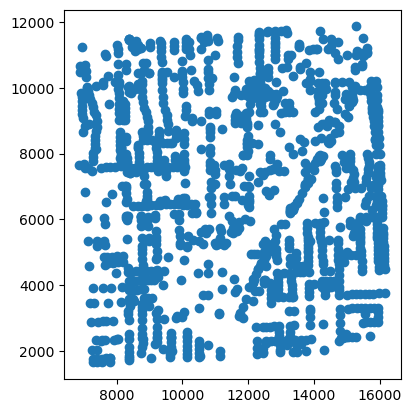

In [ ]:
im_corner_gdf_adj.plot()


In [112]:
compoundedAdjustment = np.eye(3)
compoundedAdjustment = np.linalg.inv(matrix) @ compoundedAdjustment 
compoundedAdjustment

array([[     1.1345,   -0.022593,      3612.7],
       [    0.03837,      1.0736,      968.38],
       [          0,           0,           1]])

In [128]:
current_adjustment

array([[    0.88125,    -0.01755, -1.0627e+07],
       [  -0.031501,    -0.88143,  3.4862e+06],
       [          0,           0,           1]])

In [120]:
getMatrixFromAffine(ra.transform)

array([[     0.7768,  1.3273e-13,  -1.063e+07],
       [ 4.1911e-14,    -0.82097,   3.487e+06],
       [          0,           0,           1]])

In [132]:
current_adjustment

array([[    0.88125,    -0.01755, -1.0627e+07],
       [  -0.031501,    -0.88143,  3.4862e+06],
       [          0,           0,           1]])

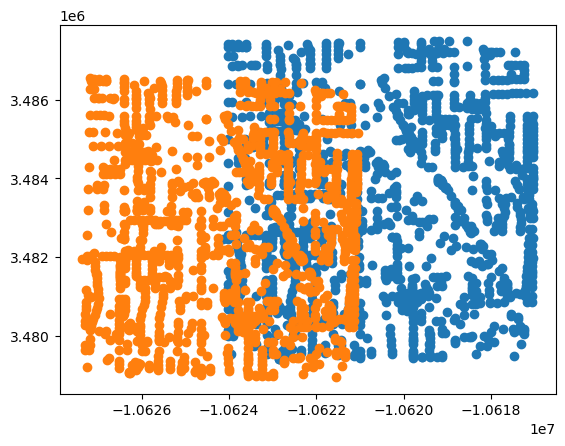

In [147]:
compoundedAdjustment = np.eye(3)
flip=np.array([
    [1, 0, 0],
    [0, -1, 0],
    [0, 0, 1]
    ]) 


prev_transform = getMatrixFromAffine(ra.transform)

for i in range(19):
    if i == 0:
        matching_results, im_corner_gdf, corners_curr = matching(im_corner_gdf, corners_curr, ratio_threshold=0.95, **descriptor_kwds)
        matrix = iterativeAdjustFromMatching(matching_results, corners_curr=corners_curr, im_corner_gdf=im_corner_gdf, plot=False)
        #fromPoints, toPoints = iterativeAdjustFromMatching(matching_results, corners_curr=corners_curr, im_corner_gdf=im_corner_gdf, plot=True)
    else:
        matching_results, _, _ = matching_distances(im_corner_gdf_adj, corners_curr, **descriptor_kwds)
        matrix = iterativeAdjustFromMatching(matching_results, plot=False)

    compoundedAdjustment = np.linalg.inv(matrix) @ compoundedAdjustment 

    # current_adjustment = compoundedAdjustment @ getMatrixFromAffine(ra.transform).T
    # current_adjustment = getMatrixFromAffine(ra.transform) @ compoundedAdjustment

    rev_adj = compoundedAdjustment @ flip
    current_adjustment = getMatrixFromAffine(ra.transform) @ flip @ rev_adj

    reprojectedcorners = np.hstack((corner_arry, np.ones((corner_arry.shape[0], 1)))) @ current_adjustment.T

    print(current_adjustment - prev_transform)

    if False:
        plt.figure()
        plt.scatter(reprojectedcorners[:, 0], reprojectedcorners[:, 1])
        test = np.hstack((corner_arry, np.ones((corner_arry.shape[0], 1)))) @  getMatrixFromAffine(ra.transform).T
        plt.scatter(test[:, 0], test[:, 1])
        plt.show()

    im_corner_gdf_adj = im_corner_gdf.copy()
    im_corner_gdf_adj['geometry'] = gpd.points_from_xy(reprojectedcorners[:,0], reprojectedcorners[:, 1])
    
    # register_transform1 = matrix @ register_transform

with rio.open("test_registration11.tif", 'w',
                driver='GTiff', count=1, dtype=np.uint8,
                height=image.shape[0], width=image.shape[1],
                crs=f'EPSG:3857',
                transform=rio.Affine(*current_adjustment.flatten()[:6])) as dst:
                    dst.write(image, 1) 

  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

24
24
[[    0.10445     0.01755      2806.3]
 [   0.031501   -0.060457      795.01]
 [          0           0           0]]


  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

393
393
[[    0.10195    0.018074      2767.7]
 [   0.018175   -0.060356      784.36]
 [          0           0           0]]


  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

483
483
[[    0.10199    0.018258      2778.6]
 [   0.021664   -0.059157       916.8]
 [          0           0           0]]


  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

424
424
[[    0.10206    0.018316      2780.2]
 [   0.018699   -0.061645      886.27]
 [          0           0           0]]


  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

458
458
[[    0.10204    0.018323      2779.7]
 [    0.01949   -0.059076      926.13]
 [          0           0           0]]


  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

446
446
[[    0.10207    0.018242      2780.2]
 [   0.018562   -0.061738      905.87]
 [          0           0           0]]


  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

448
448
[[     0.1021    0.018329      2780.1]
 [   0.019267   -0.059218      930.63]
 [          0           0           0]]


  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

448
448
[[    0.10207    0.018248      2779.8]
 [   0.018595   -0.061726      909.18]
 [          0           0           0]]


  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

446
446
[[    0.10209    0.018315      2779.9]
 [   0.019276   -0.059177      930.93]
 [          0           0           0]]


  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

448
448
[[    0.10207    0.018247      2779.9]
 [   0.018595   -0.061726      909.04]
 [          0           0           0]]


  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

446
446
[[    0.10209    0.018315        2780]
 [   0.019276   -0.059177      930.91]
 [          0           0           0]]


  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

448
448
[[    0.10207    0.018247      2779.9]
 [   0.018595   -0.061726      909.03]
 [          0           0           0]]


  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

446
446
[[    0.10209    0.018315        2780]
 [   0.019276   -0.059177      930.91]
 [          0           0           0]]


  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

448
448
[[    0.10207    0.018247      2779.9]
 [   0.018595   -0.061726      909.03]
 [          0           0           0]]


  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

446
446
[[    0.10209    0.018315        2780]
 [   0.019276   -0.059177      930.91]
 [          0           0           0]]


  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

448
448
[[    0.10207    0.018247      2779.9]
 [   0.018595   -0.061726      909.03]
 [          0           0           0]]


  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

446
446
[[    0.10209    0.018315        2780]
 [   0.019276   -0.059177      930.91]
 [          0           0           0]]


  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

448
448
[[    0.10207    0.018247      2779.9]
 [   0.018595   -0.061726      909.03]
 [          0           0           0]]


  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

446
446
[[    0.10209    0.018315        2780]
 [   0.019276   -0.059177      930.91]
 [          0           0           0]]


In [ ]:
"""
flip=np.array([
    [1, 0, 0],
    [0, -1, 0],
    [0, 0, 1]
    ]) 

rev_adj = np.linalg.inv(matrix) @ flip
output_transform = getMatrixFromAffine(ra.transform) @ flip @ rev_adj

best_transform, transform_dict = performWeightedICPonTile([street_det, im_corner_gdf], [streets, corners],proc_limit=5000, icp_iterations=90, plot_datasets=[roads_clipped, corners], weights=[1/10, 1], plot=False, shear=True, perspective=True)
register_transform = best_transform @ output_transform
"""

best_transform, transform_dict = performWeightedICPonTile([street_det, im_corner_gdf], [streets, corners],proc_limit=5000, icp_iterations=90, plot_datasets=[roads_clipped, corners], weights=[1/10, 1], plot=False, shear=True, perspective=True)

  0%|          | 0/90 [00:00<?, ?it/s]

In [ ]:
reprojectedcorners = np.hstack((corner_arry, np.ones((corner_arry.shape[0], 1)))) @ register_transform.T

im_corner_gdf_adj = im_corner_gdf.copy()
im_corner_gdf_adj['geometry'] = gpd.points_from_xy(reprojectedcorners[:,0], reprojectedcorners[:, 1])
# im_corner_gdf_adj.to_file("test.shp")

In [ ]:
out2, a, b = matching_distances(im_corner_gdf_adj, corners_curr, **descriptor_kwds)

  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/13178 [00:00<?, ?it/s]

[7, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 119, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 162, 163, 164, 165, 166, 169, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193, 194, 195, 196, 198, 199, 200, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 235, 236, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 254, 255, 256, 257, 258, 259, 2

(array([          0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           1,           8,
                 40,          40,          41,          17,          20,          42,         111,          42,           9,           0,           0,           3,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,
                  0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,
                  0,           0,       

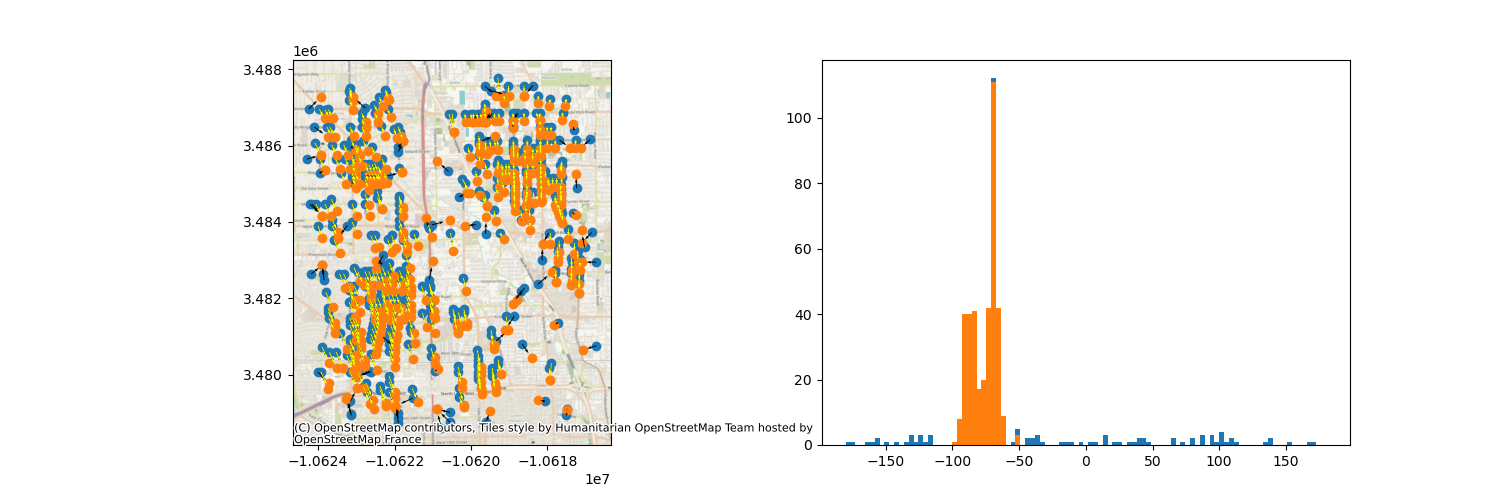

In [ ]:
out2_trim = np.array([x[:4] for x in out2])

fig, axs = plt.subplots(1, 2, figsize=(15,5))

fromPoints.plot(ax=axs[0])
toPoints.plot(ax=axs[0])

axs[0], uv = calcQuiver(axs[0], fromPoints, toPoints, color="black")

cx.add_basemap(axs[0])

angles = np.degrees(np.arctan2(uv[:, 1], uv[:, 0]))
test = np.vstack((normArry(angles), normArry(np.sqrt(uv[:, 0] ** 2, uv[:, 1] ** 2 )))).T
idx = most_popular_indices_2d(test, eps=0.04)

print(idx)

axs[0], uv = calcQuiver(axs[0], fromPoints.iloc[idx], toPoints.iloc[idx], color="yellow")

bins = np.linspace(-180, 180, 100)

axs[1].hist(angles, bins)
axs[1].hist(angles[idx], bins)

In [ ]:
initial = affineTransformation(fromPoints.iloc[idx].geometry.x.to_numpy(), 
                                   fromPoints.iloc[idx].geometry.y.to_numpy(), 
                                   toPoints.iloc[idx].geometry.x.to_numpy(), 
                                   toPoints.iloc[idx].geometry.y.to_numpy(), verbose=False)
matrix = initial.matrix

In [ ]:
matrix

array([[    0.97607,  -0.0096062, -2.2055e+05],
       [  0.0088574,      1.0256,      4433.7],
       [          0,           0,           1]])

In [ ]:
# rev_adj = np.linalg.inv(matrix) @ flip
# output_transform = register_transform @ flip @ rev_adj

register_transform1 = matrix @ register_transform

with rio.open("test_georeference2.tif", 'w',
                driver='GTiff', count=1, dtype=np.uint8,
                height=image.shape[0], width=image.shape[1],
                crs=f'EPSG:3857',
                transform=rio.Affine(*register_transform1.flatten()[:6])) as dst:
                    dst.write(image, 1) 

[7, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 119, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 162, 163, 164, 165, 166, 169, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193, 194, 195, 196, 198, 199, 200, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 235, 236, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 254, 255, 256, 257, 258, 259, 2

(array([          0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           1,           8,
                 40,          40,          41,          17,          20,          42,         111,          42,           9,           0,           0,           3,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,
                  0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,
                  0,           0,       

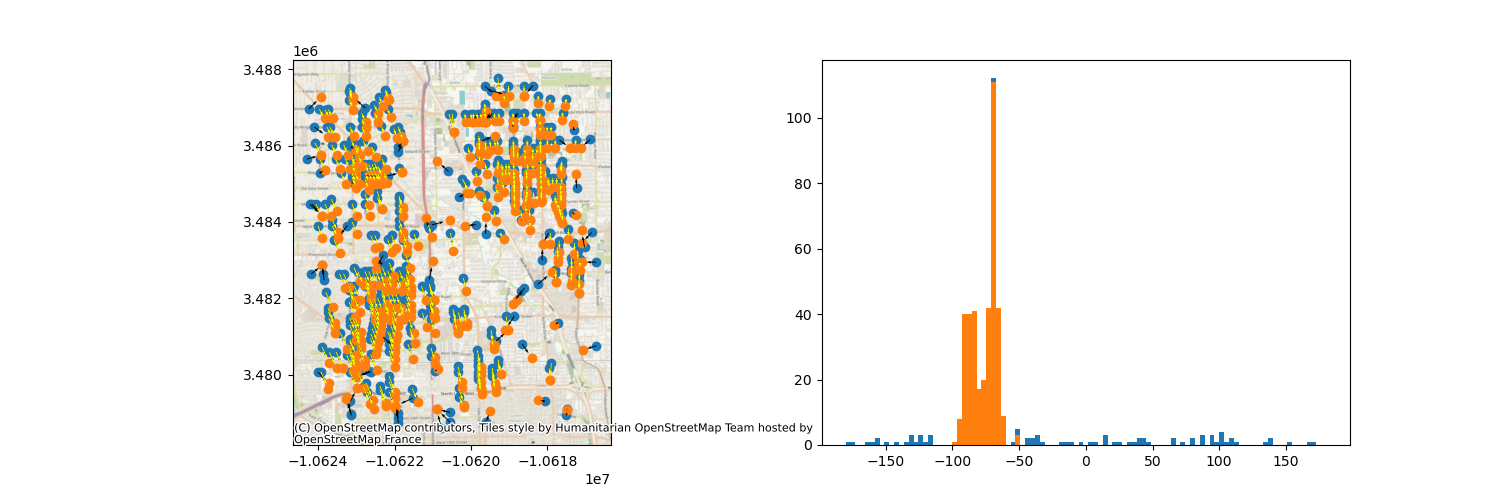

In [ ]:
out2_trim = np.array([x[:4] for x in out2])

fig, axs = plt.subplots(1, 2, figsize=(15,5))

fromPoints.plot(ax=axs[0])
toPoints.plot(ax=axs[0])

axs[0], uv = calcQuiver(axs[0], fromPoints, toPoints, color="black")

cx.add_basemap(axs[0])

angles = np.degrees(np.arctan2(uv[:, 1], uv[:, 0]))
test = np.vstack((normArry(angles), normArry(np.sqrt(uv[:, 0] ** 2, uv[:, 1] ** 2 )))).T
idx = most_popular_indices_2d(test, eps=0.04)

print(idx)

axs[0], uv = calcQuiver(axs[0], fromPoints.iloc[idx], toPoints.iloc[idx], color="yellow")

bins = np.linspace(-180, 180, 100)

axs[1].hist(angles, bins)
axs[1].hist(angles[idx], bins)

# matrix = iterativeAdjustFromMatching(matching_results, plot=True)